# GD05 Class Activation Map  
## Objective  
- CAM을 얻기 위한 기본모델의 구성과 학습이 정상 진행되었는가?  
ResNet50 + GAP + DenseLayer 결합된 CAM 모델의 학습과정이 안정적으로 수렴하였다.  
- 분류근거를 설명 가능한 Class activation map을 얻을 수 있는가?  
CAM 방식과 Grad-CAM 방식의 class activation map이 정상적으로 얻어지며, 시각화하였을 때 해당 object의 주요 특징 위치를 잘 반영한다.  
- 인식결과의 시각화 및 성능 분석을 적절히 수행하였는가?  
CAM과 Grad-CAM 각각에 대해 원본이미지합성, 바운딩박스, IoU 계산 과정을 통해 CAM과 Grad-CAM의 object localization 성능이 비교분석되었다.

In [1]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

import copy
import cv2
from PIL import Image

import os

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### 데이터셋 구성  
Stanford dogs를 사용합니다  

In [3]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Shuffling stanford_dogs-train.tfrecord...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Generating test examples...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Shuffling stanford_dogs-test.tfrecord...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Dataset stanford_dogs downloaded and prepared to /aiffel/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


In [4]:
type(ds_train)

tensorflow.python.data.ops.dataset_ops._OptionsDataset

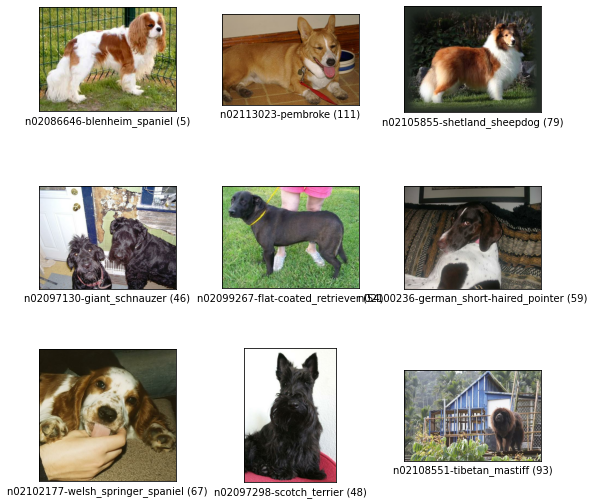

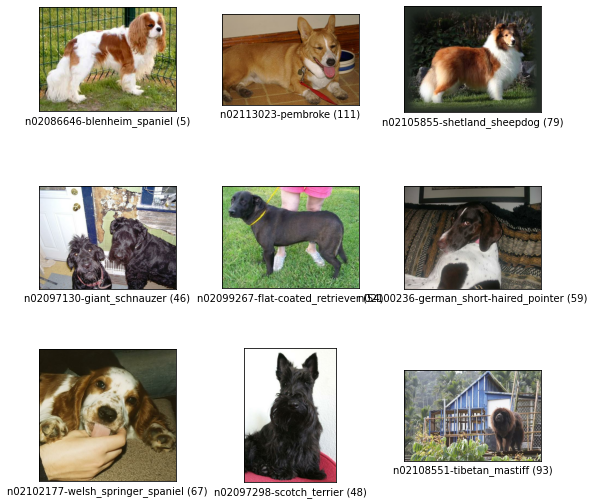

In [5]:
tfds.show_examples(ds_train, ds_info)

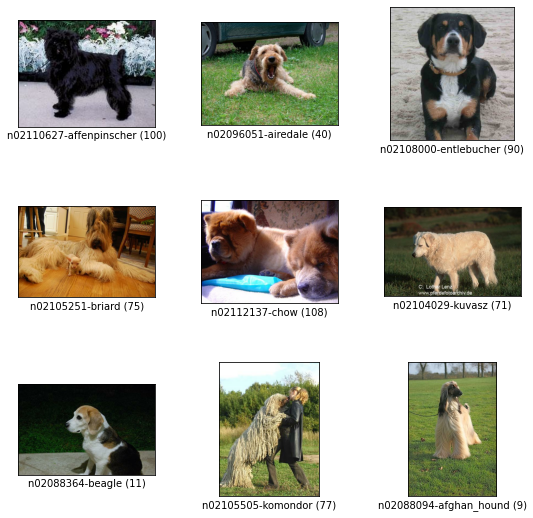

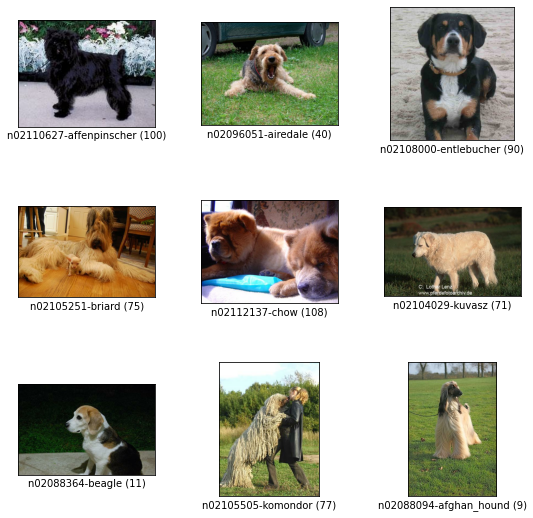

In [6]:
tfds.show_examples(ds_test, ds_info)

데이터셋의 메타정보인 Feature를 확인해보겠습니다  

In [7]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=120),
    'objects': Sequence({
        'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
    }),
})

### 전처리 함수  
데이터 normalize, resize를 수행한 후, 배치를 구성합니다  

In [8]:
def normalize_and_resize_img(input):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(input['image'], [224, 224])
    input['image'] = tf.cast(image, tf.float32) / 255.
    
    return input['image'], input['label']

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    ds = ds.batch(batch_size)
    '''
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    '''
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [9]:
# 데이터셋에 전처리와 배치처리를 적용합니다.
ds_train_norm = apply_normalize_on_dataset(ds_train)
ds_val_norm = apply_normalize_on_dataset(ds_test)

# 구성된 배치의 모양을 확인해 봅니다. 
for input in ds_train_norm.take(1):
    image, label = input
    print(image.shape)
    print(label.shape)

(16, 224, 224, 3)
(16,)


학습 데이터는 다음의 차원을 가지게 됩니다 B W H C

### 모델 구성   
CAM을 구하기 위한 기본 모델을 구현합니다  
Keras에서 제공하는 Resnet을 사용하여, 마지막에 Dense layer를 붙여 CAM model을 만들어주었습니다  
Cam model 의 GAP(Global Average Pooling)을 유의하여 적용하도록 합니다  

In [10]:
num_classes = ds_info.features["label"].num_classes
base_model = keras.applications.resnet50.ResNet50(
    include_top=False,    # Imagenet 분류기  fully connected layer 제거
    weights='imagenet',
    input_shape=(224, 224, 3),
    pooling='avg',      # GAP를 적용  
)
x = base_model.output
# preds = ADD_YOUR_LAYER(x)
preds = keras.layers.Dense(num_classes, activation='softmax')(x)
cam_model = keras.Model(inputs=base_model.input, outputs=preds)

94781440/94765736 [==============================] - 0s 0us/step


In [11]:
cam_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

일단 학습 Node에서 제공하는 대로 구현했지만, 기존의 Resnet은 1000개의 Dense 레이어를 최종레이어 이전에 사용했었습니다  
이 부분 체크해둡니다  

### 학습  
CAM모델의 학습을 진행합니다

In [12]:
EPOCHS = 50

In [13]:
cam_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'], 
)


In [14]:
history_cam_model = cam_model.fit(
    ds_train_norm,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCHS,
    validation_data=ds_val_norm,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/50
750/750 [==============================] - 164s 209ms/step - loss: 2.2710 - accuracy: 0.4329 - val_loss: 2.9042 - val_accuracy: 0.2803
Epoch 2/50
750/750 [==============================] - 156s 209ms/step - loss: 0.6470 - accuracy: 0.8312 - val_loss: 1.1801 - val_accuracy: 0.6571
Epoch 3/50
750/750 [==============================] - 156s 208ms/step - loss: 0.1771 - accuracy: 0.9743 - val_loss: 0.9863 - val_accuracy: 0.7106
Epoch 4/50
750/750 [==============================] - 156s 208ms/step - loss: 0.0599 - accuracy: 0.9967 - val_loss: 0.9846 - val_accuracy: 0.7167
Epoch 5/50
750/750 [==============================] - 156s 208ms/step - loss: 0.0297 - accuracy: 0.9987 - val_loss: 0.9626 - val_accuracy: 0.7253
Epoch 6/50
750/750 [==============================] - 156s 208ms/step - loss: 0.0196 - accuracy: 0.9995 - val_loss: 0.9606 - val_accuracy: 0.7311
Epoch 7/50
750/750 [==============================] - 156s 208ms/step - loss: 0.0141 - accuracy: 0.9998 - val_loss: 0.9850 -

In [36]:
def history_to_csv(history, filename):
    hist_df = pd.DataFrame(history.history) 
    with open(filename, mode='w') as f:
        hist_df.to_csv(f)

In [45]:
cam_model_path = os.getenv('HOME')+'/aiffel/class_activation_map/cam_model1.h5'
cam_model.save(cam_model_path)

In [39]:
history_path = os.getenv('HOME')+'/aiffel/class_activation_map/train_cam.csv'
history_to_csv(history_cam_model, cam_model_path)

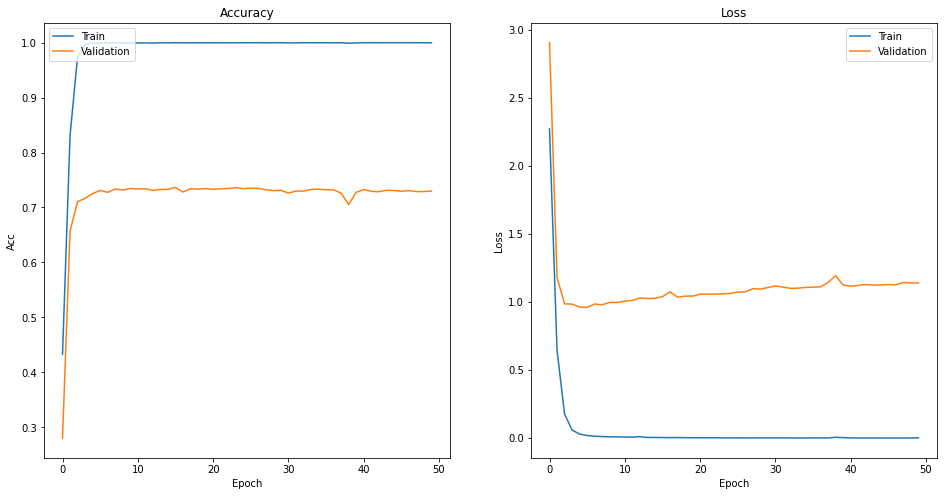

In [41]:
fig = plt.figure(figsize = (16, 8))

plt.subplot(1, 2, 1)
plt.plot(history_cam_model.history['accuracy'])
plt.plot(history_cam_model.history['val_accuracy'])
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history_cam_model.history['loss'])
plt.plot(history_cam_model.history['val_loss'])
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')


경사가 미미하지만 Overfitting 이 이루어졌습니다
학습은 5 Epoch정도만 해도 충분했을 것 같습니다  

### 테스트   
모델에서 CAM을 생성해봅니다

In [11]:
cam_model_path = os.getenv('HOME')+'/aiffel/class_activation_map/cam_model1.h5'
cam_model = tf.keras.models.load_model(cam_model_path)

In [12]:
def get_one(ds):
    ds = ds.take(1)
    sample_data = list(ds.as_numpy_iterator())
    bbox = sample_data[0]['objects']['bbox']
    image = sample_data[0]['image']
    label = sample_data[0]['label']
    return sample_data[0]


데이터 하나를 가져와, 띄워봅니다  
데이터는 이미지, 클래스, 아래 출력되지 않지만 bounding box를 가지고 있습니다  

67


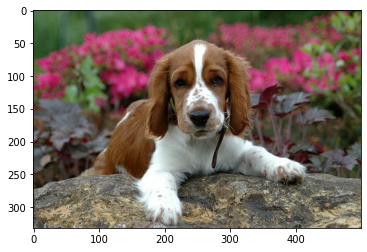

In [13]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

### CAM

In [14]:
def generate_cam(model, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # 학습한 모델에서 원하는 Layer의 output을 얻기 위해서 모델의 input과 output을 새롭게 정의해줍니다.
    # model.layers[-3].output에서는 우리가 필요로 하는 GAP 이전 Convolution layer의 output을 얻을 수 있습니다.
    cam_model = tf.keras.models.Model([model.inputs], [model.layers[-3].output, model.output])
    conv_outputs, predictions = cam_model(tf.expand_dims(img_tensor, 0))
    conv_outputs = conv_outputs[0, :, :, :]
    
    # 모델의 weight activation은 마지막 layer에 있습니다.
    class_weights = model.layers[-1].get_weights()[0] 
    
    cam_image = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
    for i, w in enumerate(class_weights[:, class_idx]):
        # conv_outputs의 i번째 채널과 i번째 weight를 곱해서 누적하면 활성화된 정도가 나타날 겁니다.
        cam_image += w * conv_outputs[:, :, i]

    cam_image /= np.max(cam_image) # activation score를 normalize합니다.
    cam_image = cam_image.numpy()
    cam_image = cv2.resize(cam_image, (width, height)) # 원래 이미지의 크기로 resize합니다.
    return cam_image


최종 레이어가 아닌 과정에서 생성된 레이어로 activation map을 얻습니다

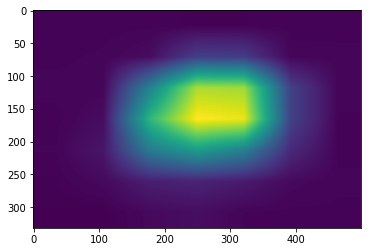

In [15]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)
plt.show()

In [16]:
def visualize_cam_on_image(src1, src2, alpha=0.5):
    beta = (1.0 - alpha)
    merged_image = cv2.addWeighted(src1, alpha, src2, beta, 0.0)
    return merged_image


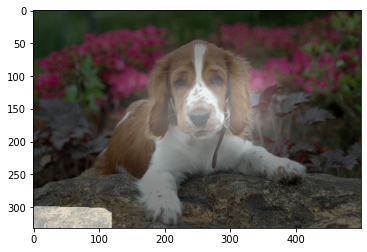

In [17]:
origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)
plt.show()

### GRAD-CAM

In [18]:
def generate_grad_cam(model, activation_layer, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # Grad cam에서도 cam과 같이 특정 레이어의 output을 필요로 하므로 모델의 input과 output을 새롭게 정의합니다.
    # 이때 원하는 레이어가 다를 수 있으니 해당 레이어의 이름으로 찾은 후 output으로 추가합니다.
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(activation_layer).output, model.output])
    
    # Gradient를 얻기 위해 tape를 사용합니다.
    with tf.GradientTape() as tape:
        conv_output, pred = grad_model(tf.expand_dims(img_tensor, 0))
    
        loss = pred[:, class_idx] # 원하는 class(여기서는 정답으로 활용) 예측값을 얻습니다.
        output = conv_output[0] # 원하는 layer의 output을 얻습니다.
        grad_val = tape.gradient(loss, conv_output)[0] # 예측값에 따른 Layer의 gradient를 얻습니다.

    weights = np.mean(grad_val, axis=(0, 1)) # gradient의 GAP으로 weight를 구합니다.
    grad_cam_image = np.zeros(dtype=np.float32, shape=conv_output.shape[0:2])
    for k, w in enumerate(weights):
        # output의 k번째 채널과 k번째 weight를 곱하고 누적해서 class activation map을 얻습니다.
        grad_cam_image += w * output[:, :, k]
        
    grad_cam_image = tf.math.maximum(0, grad_cam_image)
    grad_cam_image /= np.max(grad_cam_image)
    grad_cam_image = grad_cam_image.numpy()
    grad_cam_image = cv2.resize(grad_cam_image, (width, height))
    return grad_cam_image


grad-cam 또한 마찬가질 중간 레이어에서 값을 얻긴 하는데, gradient의 변화를 추적합니다  
코드상으로는 torch.grad가 연상이 되는 gradient tape에 접근하여, average를 구한 뒤 propagation을 재현하며 값을 누적시켜주는 과정입니다  
이후 grad CAM을 얻게됩니다  

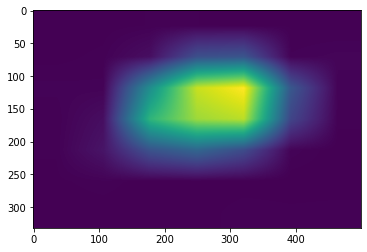

In [19]:
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

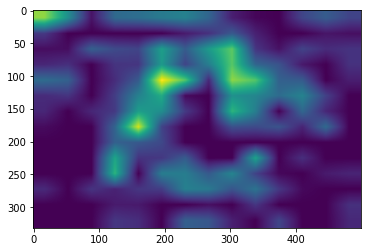

In [20]:
grad_cam_image = generate_grad_cam(cam_model, 'conv4_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

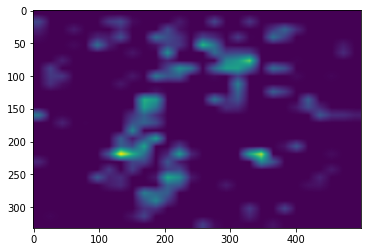

In [21]:
grad_cam_image = generate_grad_cam(cam_model, 'conv3_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

### Detection with CAM

100


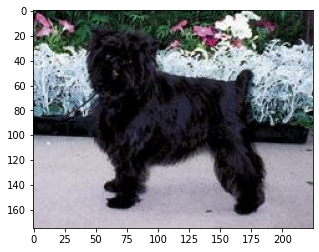

In [45]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

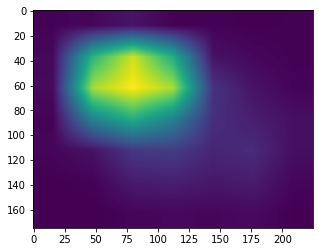

In [46]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)
plt.show()

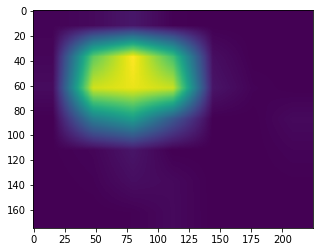

In [47]:
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

### BBOX

In [48]:
def get_bbox(cam_image, score_thresh=0.05):
    low_indicies = cam_image <= score_thresh
    cam_image[low_indicies] = 0
    cam_image = (cam_image*255).astype(np.uint8)
    
    contours,_ = cv2.findContours(cam_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    rotated_rect = cv2.minAreaRect(cnt)
    rect = cv2.boxPoints(rotated_rect)
    rect = np.int0(rect)
    return rect

In [49]:
rect = get_bbox(cam_image)
rect

array([[-18,  74],
       [ 63, -35],
       [228,  86],
       [146, 196]])

In [50]:
rect_grad = get_bbox(grad_cam_image)
rect_grad

array([[ 17,   0],
       [147,   0],
       [147, 119],
       [ 17, 119]])

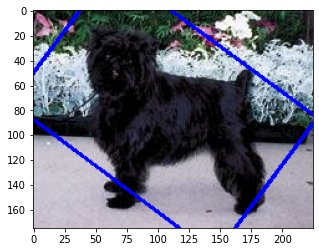

In [51]:
image = copy.deepcopy(item['image'])
image = cv2.drawContours(image, [rect], 0, (0,0,255), 2)
plt.imshow(image)
plt.show()

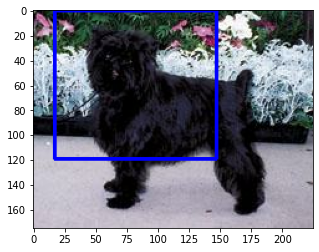

In [52]:
image = copy.deepcopy(item['image'])
image = cv2.drawContours(image, [rect_grad], 0, (0,0,255), 2)
plt.imshow(image)
plt.show()

In [53]:
# rect의 좌표는 (x, y) 형태로, bbox는 (y_min, x_min, y_max, x_max)의 normalized 형태로 주어집니다. 
def rect_to_minmax(rect, image):
    bbox = [
        rect[:,1].min()/float(image.shape[0]),  #bounding box의 y_min
        rect[:,0].min()/float(image.shape[1]),  #bounding box의 x_min
        rect[:,1].max()/float(image.shape[0]), #bounding box의 y_max
        rect[:,0].max()/float(image.shape[1]) #bounding box의 x_max
    ]
    return bbox


In [54]:
pred_bbox = rect_to_minmax(rect, item['image'])
pred_bbox

[-0.2, -0.08, 1.12, 1.0133333333333334]

In [57]:
pred_bbox_grad = rect_to_minmax(rect_grad, item['image'])
pred_bbox_grad

[0.0, 0.07555555555555556, 0.68, 0.6533333333333333]

In [58]:
item['objects']['bbox']

array([[0.08      , 0.16444445, 0.94857144, 0.84      ]], dtype=float32)

In [59]:
def get_iou(boxA, boxB):
    y_min = max(boxA[0], boxB[0])
    x_min= max(boxA[1], boxB[1])
    y_max = min(boxA[2], boxB[2])
    x_max = min(boxA[3], boxB[3])
    
    interArea = max(0, x_max - x_min) * max(0, y_max - y_min)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    iou = interArea / float(boxAArea + boxBArea - interArea)

    return iou

In [60]:
print(get_iou(pred_bbox, item['objects']['bbox'][0]))

0.406574466143902


In [61]:
print(get_iou(pred_bbox_grad, item['objects']['bbox'][0]))

0.42739785803847785


In [ ]:
Grad Cam이 살짝 더 높은 성능을 보여줬습니다  
일반적인 IoU의 수치로 보기에는 많이 낮은 값이겠지만, saliency detection task로 생각해볼때는 cost에 비해 effecient한 결과라고 생각합니다  

# 회고  
예제에서 가져오는 것으로 모든 매트릭을 채울 수 있던 노드였습니다 제출은 못했지만..  
코어가 되는 부분의 코드를 한줄한줄 뜯어서 보면서, 이론상으로 체감되지 않던 부분이 다가왔던 점이 좋았습니다  
## Future work  
원논문  
CAM : http://cnnlocalization.csail.mit.edu/Zhou_Learning_Deep_Features_CVPR_2016_paper.pdf  
GradCAM : https://arxiv.org/abs/1610.02391  
### 재학습  
해당 모델은 data shuffle이 되지 않은 dataset을 훈련하였습니다  
OD 결과물에서 확인하였듯이, 모델 학습의 초기값은 매우 중요했습니다  
shuffle이 이루어 질 시, 어떤 변화가 있을 지 보겠습니다  
### 재평가  
Cam과 GradCam 의 IoU 평가에 대해, 한개의 데이터를 사용한 평가이기 때문에 정량적으로 증명되지 않았습니다  
원 논문에서는 VGG 16을 백본 네트워크로, Pascal VOC 2012 Segmetation task Dataset을 기준으로 44.6 / 49.6의 기준치를 달성했습니다  
또한, GradCam의 원 논문의 경우, IoU 보다도 Top 1/5 Accuracy/ Localization error를 주요 메트릭으로 소개하며,  
Classification / Localization task 의 다양한 응용가능성을 소개하고 있습니다  
해당 메트릭에 대해서도 바른 방법으로 구현이 되었는지 평가해보도록 하겠습니다  
### 모델 확장  
원 논문에서는 Backbone network로 VGG16, Alexnet, GoogleNet을 사용하였습니다  
시기상 이 프로젝트에서 사용된 ResNet보다 먼저 소개된 모델들인데다가, ResNet은 이전 모델들보다 Model Complexity를 늘려가며 성능을 높히는 데에 초점이 맞추어져 있어, 같은 메트릭을 사용할 경우 일반적으로는 더 나은 결과를 보여주게 될 것입니다  
이 가정이 사실일지, 만약 그렇다면 기존 모델들에 비해 얼마나 개선점이 있을 지 확인할 예정이며, Pre-built model을 사용하면, 어렵지 않은 task가 될 것으로 예상하고 있습니다